In [82]:
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import marsilea as ma
import marsilea.plotter as mp
import scienceplots
# %matplotlib widget
import pickle
plt.style.use(['science', 'nature'])
import numpy as np
from itertools import combinations, product
import pingouin as pg
from matplotlib.patches import Rectangle
from marsilea.plotter import FixedChunk
from matplotlib.colors import LinearSegmentedColormap

In [83]:
tool_map = {
    "scapa": "scAPA",
    "scapatrap": "scAPAtrap",
    "sierra": "Sierra",
    "maaper": "MAAPER",
    "scapture": "SCAPTURE",
    "scape": "SCAPE",
    "infernape": "Infernape",
}

protocol_map = {
    "Visium": "10X Visium",
    "VisiumHD": "10X Visium HD",
    "Chromium": "10X Chromium",
    "Dropseq": "Drop-seq",
    "Stereoseq": "Stereo-seq",
    "Slideseq": "Slide-seq V2",
    "SpatialTranscriptomics": "ST",
    "Microwell": "Microwell-seq",
}

protocol_order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium","Stereo-seq", "Slide-seq V2", "ST"]
tool_order = ["SCAPE", "scAPAtrap", "Infernape", "SCAPTURE", "scAPA",  "Sierra"]

color = [
    "#386b98",
    "#269a51",
    "#edaa4d",
    "#d34123",
    "#7e648a",
    "#454545",
    "#929292",
]

palette=sns.color_palette(color, 7)
mm = 1/25.4

plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 5
plt.rcParams["legend.title_fontsize"] = 6
plt.rcParams['hatch.linewidth'] = 0.5

In [84]:
with open("/root/apabenchmark/data/archive_pickle/raw_data_feature_df.pkl", "rb") as f:
    raw_data_feature_df = pickle.load(f)

In [85]:
match_performance_df = pd.read_csv("/root/apabenchmark/data/performance/match_performance.tsv", sep="\t")
quantify_performance_df = pd.read_csv("/root/apabenchmark/data/performance/pas_quantification_performance.tsv", sep="\t")
de_apa_performance_df = pd.read_csv("/root/apabenchmark/data/performance/de_apa_performance_filtered.tsv", sep="\t")

match_performance_df = (match_performance_df
                        .pivot(index=["sample", "tool"], columns="match_type", values=["f1", "precision", "recall"])
                        )
match_performance_df.columns = ["_".join(col[::-1]) for col in match_performance_df.columns]
match_performance_df = match_performance_df.reset_index()
de_apa_performance_df = (de_apa_performance_df.groupby(["tool", "sample"])
                         .apply(lambda x: x.sort_values('f1', ascending=False).head(1))
                         .reset_index(drop=True)
                         .rename(columns={"precision": "de_precision", "recall":"de_recall", "f1": "de_f1"}))

In [86]:
match_performance_df["raw_sample"] = match_performance_df["sample"].apply(lambda x: "_".join(x.split("_")[:4]))
quantify_performance_df["raw_sample"] = quantify_performance_df["sample"].apply(lambda x: "_".join(x.split("_")[:4]))
de_apa_performance_df["raw_sample"] = de_apa_performance_df["sample"].apply(lambda x: "_".join(x.split("_")[:4]))

In [87]:
over_all_performance_df = (match_performance_df
                           .merge(quantify_performance_df, on=["sample", "tool", "raw_sample"], how="left")
                           .merge(de_apa_performance_df, on=["sample", "tool", "raw_sample"], how="left")
                            .merge(raw_data_feature_df, left_on=["raw_sample"], right_on=["sample"], how="left")
)
over_all_performance_df["tool"] = over_all_performance_df["tool"].map(tool_map)
over_all_performance_df = over_all_performance_df.groupby(["tool", "raw_sample"]).mean(numeric_only=True)

In [88]:
pc_result_list = []
y_var_list = ["de_f1","de_recall","de_precision"]
x_var_list = [
    "pas_precision", "pas_recall", "te_precision", "te_recall", "rmse_pas", "rmse_pas_ct",
    ]

for tool in tool_order:
    for y_var in y_var_list:
        pc_df = over_all_performance_df.loc[tool,x_var_list+[y_var]]
        for x_var in x_var_list:
            covar = list(set(x_var_list) - {x_var})
            pc_result = pg.partial_corr(data=pc_df, x=x_var, y=y_var, covar=covar, method="spearman").loc["spearman",:].to_dict()
            pc_result["tool"] = tool
            pc_result["y_var"] = y_var
            pc_result["x_var"] = x_var
            pc_result_list.append(pc_result)

pc_result_df = pd.DataFrame(pc_result_list)
pc_result_df.loc[pc_result_df["p-val"] > 0.05, "r"] = np.nan
pc_result_df["tool"] = pd.Categorical(pc_result_df["tool"], categories=tool_order, ordered=True)
pc_result_df["y_var"] = pd.Categorical(pc_result_df["y_var"], categories=y_var_list, ordered=True)
pc_r_matrix = pc_result_df.pivot(index=["tool", "y_var"], columns="x_var", values="r").reset_index().sort_values(["y_var","tool"]).loc[:, x_var_list].reset_index(drop=True).values
pc_p_matrix = pc_result_df.pivot(index=["tool", "y_var"], columns="x_var", values="p-val").reset_index().sort_values(["y_var","tool"]).loc[:, x_var_list].reset_index(drop=True).values
pc_r_matrix = pc_r_matrix.astype(float)
pc_p_matrix = pc_p_matrix.astype(float)

tool_num = len(tool_order)
var_num = len(x_var_list)
pc_r_matrix_final = np.column_stack([pc_r_matrix[i*tool_num:(i+1)*tool_num,:] for i in range(len(y_var_list))])
pc_p_matrix_final = np.column_stack([pc_p_matrix[i*tool_num:(i+1)*tool_num,:] for i in range(len(y_var_list))])

tool_label_list = tool_order

x_var_label_map = {
    "pas_precision": "pA site \nprecision",
    "pas_recall": "pA site recall",
    "pas_f1": "pA site F1",
    "te_precision": "Multi-pA-site \nTE precision",
    "te_recall": "Multi-pA-site \nTE recall",
    "te_f1": "TE F1",
    "mape_pas": "pA site MPAE \n(barcode level)",
    "mape_pas_ct": "pA site MPAE \n(group level)",
    "rmse_pas": "pA site RMSE \n(barcode level)",
    "rmse_pas_ct": "pA site RMSE \n(group level)",
}
x_var_label_list = [x_var_label_map[x] for x in x_var_list]*len(y_var_list)

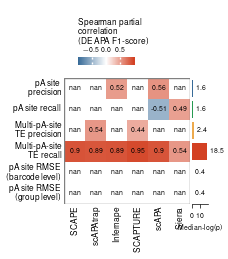

In [89]:
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.minor.bottom"] = True
plt.rcParams["ytick.left"] = False

cmap = LinearSegmentedColormap.from_list('custom', [palette[0],"white", palette[3]])
value_mtx = np.transpose(pc_r_matrix_final[:,0:var_num])

h = ma.Heatmap(
    value_mtx,
    cmap=cmap,
    label="Spearman partial \n correlation \n (DE APA F1-score)",
    width=32*mm,
    height=32*mm,
    cbar_kws={"orientation": "horizontal","width":8, "height":1},
    vmax=1,
    vmin=-1
)
h.add_layer(mp.TextMesh(np.around(value_mtx,2), color="black", fontsize=5))
h.add_right(mp.Numbers(
    np.around(-np.median(np.log(pc_p_matrix_final[:,0:var_num]), axis=0),1),
    color=palette[0:6][::-1], 
    label="Median -log(p)",
    show_value=True,
    props={"fontsize": 5}
    ), 
    size=4*mm,
    pad=0.5*mm
    )



h.add_left(mp.Labels([x_var_label_map[x] for x in x_var_list], fontsize=6), pad=0.5*mm)
h.add_bottom(mp.Labels(tool_label_list, rotation=90, fontsize=6), pad=0.5*mm)
h.add_legends("top")
h.render()

ax = h.get_main_ax()
ax.padded = 0.1
border = Rectangle((0, 0), 1, 1, fill=False, ec="grey", lw=1, transform=ax.transAxes)
ax.add_artist(border)

plt.savefig('/root/apabenchmark/plot/fig5/de_apa_f1_partial_corr.pdf', bbox_inches='tight', dpi=300)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.minor.bottom"] = False

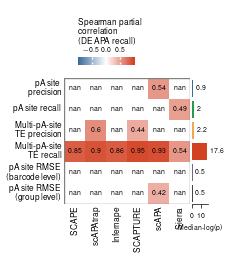

In [90]:
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.minor.bottom"] = True
plt.rcParams["ytick.left"] = False

cmap = LinearSegmentedColormap.from_list('custom', [palette[0],"white", palette[3]])
value_mtx = np.transpose(pc_r_matrix_final[:,var_num:var_num*2])

h = ma.Heatmap(
    value_mtx,
    cmap=cmap,
    label="Spearman partial \n correlation \n (DE APA recall)",
    width=32*mm,
    height=32*mm,
    cbar_kws={"orientation": "horizontal","width":8, "height":1},
    vmax=1,
    vmin=-1
)
h.add_layer(mp.TextMesh(np.around(value_mtx,2), color="black", fontsize=5))
h.add_right(mp.Numbers(
    np.around(-np.median(np.log(pc_p_matrix_final[:,var_num:var_num*2]), axis=0),1),
    color=palette[0:6][::-1], 
    label="Median -log(p)",
    show_value=True,
    props={"fontsize": 5}
    ), 
    size=4*mm,
    pad=0.5*mm
    )



h.add_left(mp.Labels([x_var_label_map[x] for x in x_var_list], fontsize=6), pad=0.5*mm)
h.add_bottom(mp.Labels(tool_label_list, rotation=90, fontsize=6), pad=0.5*mm)
h.add_legends("top")
h.render()

ax = h.get_main_ax()
ax.padded = 0.1
border = Rectangle((0, 0), 1, 1, fill=False, ec="grey", lw=1, transform=ax.transAxes)
ax.add_artist(border)


plt.savefig('/root/apabenchmark/plot/fig5/de_apa_recall_partial_corr.pdf', bbox_inches='tight', dpi=300)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.minor.bottom"] = False

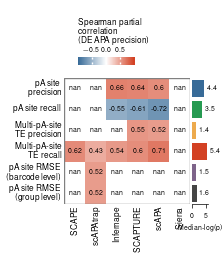

In [91]:
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.minor.bottom"] = True
plt.rcParams["ytick.left"] = False

cmap = LinearSegmentedColormap.from_list('custom', [palette[0],"white", palette[3]])
value_mtx = np.transpose(pc_r_matrix_final[:,var_num*2:var_num*3])

h = ma.Heatmap(
    value_mtx,
    cmap=cmap,
    label="Spearman partial \n correlation \n (DE APA precision)",
    width=32*mm,
    height=32*mm,
    cbar_kws={"orientation": "horizontal","width":8, "height":1},
    vmax=1,
    vmin=-1
)
h.add_layer(mp.TextMesh(np.around(value_mtx,2), color="black", fontsize=5))
h.add_right(mp.Numbers(
    np.around(-np.median(np.log(pc_p_matrix_final[:,var_num*2:var_num*3]), axis=0),1),
    color=palette[0:6][::-1], 
    label="Median -log(p)",
    show_value=True,
    props={"fontsize": 5}
    ), 
    size=4*mm,
    pad=0.5*mm
    )



h.add_left(mp.Labels([x_var_label_map[x] for x in x_var_list], fontsize=6), pad=0.5*mm)
h.add_bottom(mp.Labels(tool_label_list, rotation=90, fontsize=6), pad=0.5*mm)
h.add_legends("top")
h.render()

ax = h.get_main_ax()
ax.padded = 0.1
border = Rectangle((0, 0), 1, 1, fill=False, ec="grey", lw=1, transform=ax.transAxes)
ax.add_artist(border)


plt.savefig('/root/apabenchmark/plot/fig5/de_apa_precision_partial_corr.pdf', bbox_inches='tight', dpi=300)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.minor.bottom"] = False

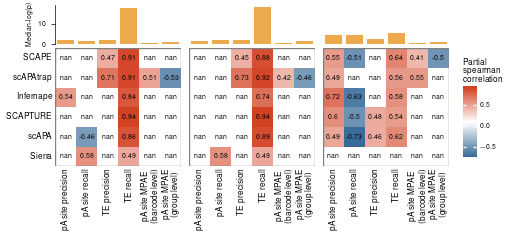

In [27]:


# tool_num = len(tool_order)
# var_num = len(x_var_list)

# plt.rcParams["xtick.direction"] = "out"
# plt.rcParams["ytick.direction"] = "out"
# plt.rcParams["xtick.bottom"] = False
# plt.rcParams["xtick.minor.bottom"] = True
# plt.rcParams["ytick.left"] = False

# cmap = LinearSegmentedColormap.from_list('custom', [palette[0],"white", palette[3]])
# h = ma.Heatmap(pc_r_matrix_final,
#                cmap=cmap,
#                 width=100*mm,
#                 height=30*mm,
#                 label="Partial\nspearman\ncorrelation"
#                 )
# h.add_layer(mp.TextMesh(np.around(pc_r_matrix_final,2), color="black", fontsize=5))
# h.add_top(mp.Numbers(
#     -np.median(np.log(pc_p_matrix_final), axis=0),
#     color="#edaa4d", 
#     label="Median -log(p)",
#     show_value=False,
#     ), 
#     size=10*mm, 
#     pad=1*mm,
#     name="top"
#     )
# h.cut_cols(list(range(var_num, var_num*len(y_var_list), var_num)), spacing=0.02)
# h.add_left(mp.Labels(tool_label_list, fontsize=6), pad=0.5*mm)
# h.add_bottom(mp.Labels(x_var_label_list, rotation=90, fontsize=6), pad=0.5*mm)
# h.add_legends(pad=0)
# h.render()

# hax = h.get_main_ax()
# for ax in hax:
#     ax.padded = 0.1
#     border = Rectangle((0, 0), 1, 1, fill=False, ec="grey", lw=1, transform=ax.transAxes)
#     ax.add_artist(border)

# plt.savefig("/root/apabenchmark/plot/fig5/de_apa_partial_corr_heatmap.pdf", bbox_inches="tight", dpi=300)
# plt.rcParams["xtick.direction"] = "in"
# plt.rcParams["ytick.direction"] = "in"
# plt.rcParams["xtick.bottom"] = True
# plt.rcParams["ytick.left"] = True
# plt.rcParams["xtick.minor.bottom"] = False


In [12]:
over_all_performance_df.columns

Index(['pas_f1', 'te_f1', 'pas_precision', 'te_precision', 'pas_recall',
       'te_recall', 'cor_pas', 'rmse_pas', 'mae_pas', 'mape_pas',
       'rmse_pas_ct', 'mae_pas_ct', 'mape_pas_ct', 'de_precision', 'de_recall',
       'de_f1', 'read_length', 'apex_position_mean', 'apex_position_std',
       'kurtosis_mean', 'kurtosis_std', 'apex_position_median',
       'kurtosis_median', 'peak_size_median', 'peak_size_mean',
       'peak_size_std', 'edge_position_mean', 'edge_position_std',
       'edge_position_median', 'skewness_mean', 'skewness_std',
       'skewness_median', 'peak_height_mean', 'peak_height_std',
       'peak_height_median'],
      dtype='object')

In [92]:
pc_result_list = []
y_var_list = ["pas_f1","te_f1","rmse_pas","rmse_pas_ct","de_f1","de_precision"]
# x_var_list = ["peak_height_median", "peak_height_std", "apex_position_median", "apex_position_std", "edge_position_median", "edge_position_std", "kurtosis_median", "kurtosis_std", "skewness_median", "skewness_std"]
x_var_list = [
        "peak_height_mean",
        "apex_position_mean", 
        "edge_position_mean", 
        "kurtosis_mean", 
        "skewness_mean",
        "peak_height_std", 
        "apex_position_std", 
        "edge_position_std",
        "kurtosis_std", 
        "skewness_std"
    ]

# x_var_list = ["peak_size_median", "apex_position_median", "apex_position_var", "edge_position_median", "edge_position_var", "kurtosis_median"]
for tool in tool_order:
    for y_var in y_var_list:
        pc_df = over_all_performance_df.loc[tool,x_var_list+[y_var]]
        for x_var in x_var_list:
            covar = list(set(x_var_list) - {x_var})
            pc_result = pg.partial_corr(data=pc_df, x=x_var, y=y_var, covar=covar,method="spearman").loc["spearman",:].to_dict()
            pc_result["tool"] = tool
            pc_result["y_var"] = y_var
            pc_result["x_var"] = x_var
            pc_result_list.append(pc_result)

In [93]:
pc_result_df = pd.DataFrame(pc_result_list)
pc_result_df.loc[pc_result_df["p-val"] > 0.05, "r"] = np.nan
pc_result_df["tool"] = pd.Categorical(pc_result_df["tool"], categories=tool_order, ordered=True)
pc_result_df["y_var"] = pd.Categorical(pc_result_df["y_var"], categories=y_var_list, ordered=True)
pc_r_matrix = pc_result_df.pivot(index=["tool", "y_var"], columns="x_var", values="r").reset_index().sort_values(["y_var","tool"]).loc[:, x_var_list].reset_index(drop=True).values
pc_p_matrix = pc_result_df.pivot(index=["tool", "y_var"], columns="x_var", values="p-val").reset_index().sort_values(["y_var","tool"]).loc[:, x_var_list].reset_index(drop=True).values
pc_r_matrix = pc_r_matrix.astype(float)
pc_p_matrix = pc_p_matrix.astype(float)

tool_num = len(tool_order)
var_num = len(x_var_list)
pc_r_matrix_final = np.column_stack([pc_r_matrix[i*tool_num:(i+1)*tool_num,:] for i in range(len(y_var_list))])
pc_p_matrix_final = np.column_stack([pc_p_matrix[i*tool_num:(i+1)*tool_num,:] for i in range(len(y_var_list))])

# pc_r_matrix_final = np.column_stack([pc_r_matrix[0:6,:], pc_r_matrix[6:12,:], pc_r_matrix[12:18,:], pc_r_matrix[18:24,:], pc_r_matrix[24:30,:], pc_r_matrix[30:,:]])
# pc_p_matrix_final = np.column_stack([pc_p_matrix[0:6,:], pc_p_matrix[6:12,:], pc_p_matrix[12:18,:], pc_p_matrix[18:24,:], pc_p_matrix[24:30,:], pc_p_matrix[30:,:]])

tool_label_list = tool_order

x_var_label_map = {
    "peak_height_mean": "Peak height",
    "peak_height_std": "Peak height SD",
    "apex_position_mean": "Apex postion",
    "apex_position_std": "Apex position SD",
    "edge_position_mean": "Edge position",
    "edge_position_std": "Edge position SD",
    "kurtosis_mean": "Kurtosis",
    "kurtosis_std": "Kurtosis SD",
    "skewness_mean": "Skewness",
    "skewness_std": "Skewness SD",
}
# x_var_label_list = ["Peak size median", "Apex position median", "Apex position variance", "Edge position median", "Edge position variance", "Kurtosis median", "Kurtosis variance"]*6
y_var_label_list = [
    "pA site F1",
    "TE F1",
    "MPAE (pA site, cell level)",
    "MPAE (pA site, cell-type level)",
    "DE APA F1",
    "DE APA precision",
]
x_var_label_list = [x_var_label_map[x] for x in x_var_list]*len(y_var_list)

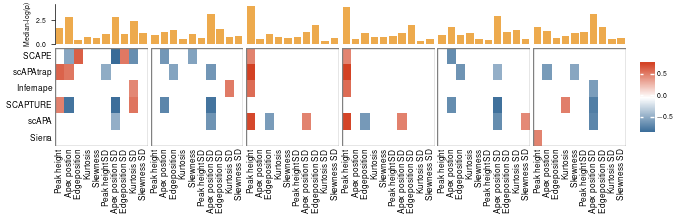

In [94]:
from matplotlib.patches import Rectangle
from marsilea.plotter import FixedChunk
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.minor.bottom"] = True
plt.rcParams["ytick.left"] = False

cmap = LinearSegmentedColormap.from_list('custom', [palette[0],"white", palette[3]])
h = ma.Heatmap(pc_r_matrix_final,
               cmap=cmap,
            width=145*mm,
                height=25*mm)

# h.add_layer(ma.plotter.TextMesh(np.around(pc_r_matrix_final,2), fontsize=5, color="black"))
# h.add_right(mp.Chunk(["" for x in range(24)], fill_colors=list(palette)*4), pad=0.1)
h.add_top(mp.Numbers(
    -np.median(np.log(pc_p_matrix_final), axis=0),
    color="#edaa4d", 
    label="Median -log(p)",
    show_value=False,
    ), 
    size=10*mm,     
    pad=1*mm,
    )
h.cut_cols(list(range(var_num, var_num*len(y_var_list), var_num)), spacing=0.005)
h.add_left(mp.Labels(tool_label_list, fontsize=6), pad=0.5*mm)
h.add_bottom(mp.Labels(x_var_label_list, rotation=90, fontsize=6), pad=0.5*mm)
h.add_legends(pad=0)
# h.add_top(mp.Chunk(y_var_label_list, fill_colors=palette))
h.render()
hax = h.get_main_ax()
colors = palette[0:6]
for ax, c in zip(hax, colors):
    ax.padded = 0.1
    border = Rectangle((0, 0), 1, 1, fill=False, ec="grey", lw=1, transform=ax.transAxes)
    ax.add_artist(border)


plt.savefig("/root/apabenchmark/plot/fig5/partial_corr_heatmap.pdf", bbox_inches="tight", dpi=300)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.minor.bottom"] = False


In [32]:
pg.__version__

'0.5.4'